In [17]:
# !pip install plotly ipywidgets
# from google.colab import output
# output.enable_custom_widget_manager()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display
from ipywidgets import widgets, HBox, VBox, interactive_output

In [4]:
def sequenciamento(df, A, B, C):

    """
    Sequenciamento de blocos, retornado probabilisticamente conforme pesos de A, B e C.
    Novas variáveis:
    1. Selection Prob: Probabilidade da classe ser escolhida.
    2. Start Time: Hora do início do procesamento na usina, dada sequencialmente.
    """
    total = A + B + C
    probabilidades = {'A': A/total, 'B': B/total, 'C': C/total}
    df['selection_prob'] = df['Working Face'].map(probabilidades)
    queue = df.sample(n = df.shape[0], weights='selection_prob', replace = False, random_state = 101)['Working Face'].reset_index(drop = True)

    df_sequenciado = pd.DataFrame()

    for group, df_items in df.groupby('Working Face'):
        df_items.index = queue[queue == group].index
        df_sequenciado = pd.concat([df_sequenciado, df_items])
    df_sequenciado = df_sequenciado.sort_index(ascending = True)
    df_sequenciado['start_time'] = np.cumsum(df_sequenciado['Comminution Time'].shift(1).fillna(0))
    return df_sequenciado

def fluxo_de_turnos(df_sequenciado, col = 'Fe', h = 8):

    """
    Tem como entrada o DataFrame sequenciado, utilizando o StartTime para dividir turnos baseado em horas.
    """

    df_sequenciado['Turno'] = (df_sequenciado['start_time'] // h) + 1
    df_turnos = df_sequenciado.groupby('Turno')[list(set([col] + ['Fe', 'Fe Recovery', 'Specific Energy']))].mean().reset_index()
    return df_turnos

Text(0.5, 0, 'Fe')

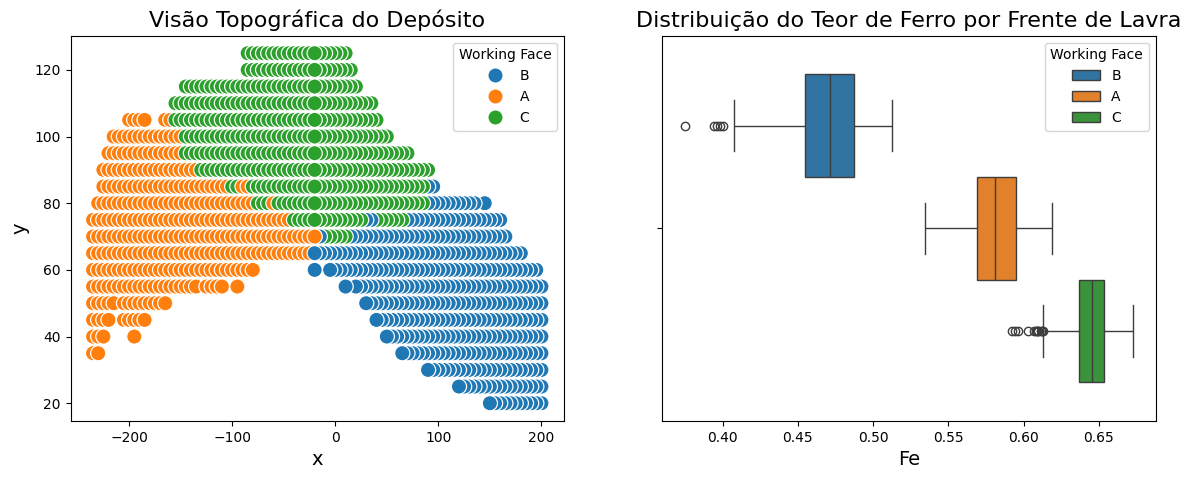

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/gstvortiz/GeoMet-UFMG-2024/main/data.csv")

fig, axs = plt.subplots(1, 2, figsize = (14, 5))
sns.scatterplot(data = df, x = 'x', y = 'y', s = 120, hue = 'Working Face', palette = 'tab10', ax = axs[0])
axs[0].set_title('Visão Topográfica do Depósito', fontsize = 16)
axs[0].set_xlabel('x', fontsize = 14)
axs[0].set_ylabel('y', fontsize = 14)
sns.boxplot(data = df, x = 'Fe', hue = 'Working Face', palette = 'tab10', ax = axs[1])
axs[1].set_title('Distribuição do Teor de Ferro por Frente de Lavra', fontsize = 16)
axs[1].set_xlabel('Fe', fontsize = 14)

In [6]:
h = 24
col = 'Fe Recovery'

In [7]:
data = list()
grid = pd.DataFrame(np.column_stack([i.ravel() for i in np.meshgrid(*[np.arange(0.1, 1, 0.05) for _ in range(3)])]), columns = ['A', 'B', 'C'])
grid = grid.loc[grid.apply(lambda row: row / sum(row), axis = 1).round(2).drop_duplicates().index]
for A, B, C in grid.values:
    df_sequenciado = sequenciamento(df, A, B, C)
    df_turnos = fluxo_de_turnos(df_sequenciado, col, h = h)
    data.append([df_turnos['Fe'].max() - df_turnos['Fe'].min(), df_turnos['Fe'].std() / df_turnos['Fe'].mean()])
grid[['range', 'std']] = data
grid['modulo'] = np.linalg.norm(grid[['range', 'std']], axis = 1)
vetor_menor_modulo = grid.loc[grid['modulo'].idxmin()]
vetor_maior_modulo = grid.loc[grid['modulo'].idxmax()]
vetor_menor_modulo

A         0.550000
B         0.850000
C         0.750000
range     0.077092
std       0.033515
modulo    0.084062
Name: 5035, dtype: float64

In [8]:
fig = px.scatter(grid, x = 'range', y = 'std', hover_data = ['A', 'B', 'C'], title = 'Análise de Métricas', color_continuous_scale = 'Turbo_R')
fig.update_layout(xaxis_title = 'Amplitude Máxima', yaxis_title = 'Desvio Padrão', hovermode='closest', width = 1400, height = 700)

In [14]:
# Criar uma figura com uma grade 2x2 de subplots
fig = go.FigureWidget(make_subplots(rows = 2, cols = 2))
fig.update_layout(width = 1400, height = 700, showlegend = False)

# Função de Atualização
def update_plot(A, B, C, Block, col = 'Fe'):
    df_sequenciado = sequenciamento(df, A, B, C)
    df_turnos = fluxo_de_turnos(df_sequenciado, col = col, h = h)

    df_sequenciado_filtrado = df_sequenciado.iloc[::-1].iloc[:-Block]
    fig.data[0].x = df_sequenciado_filtrado['x']
    fig.data[0].y = df_sequenciado_filtrado['y']
    fig.data[0].marker.color = df_sequenciado_filtrado['Working Face'].map({'A': 'Orange', 'B': 'Blue', 'C': 'Green'})

    turno_atual = df_sequenciado_filtrado['Turno'].min() if df_sequenciado_filtrado.shape[0] else df_sequenciado['Turno'].max()
    df_turnos_filtrado = df_turnos.query('Turno <= @turno_atual')
    fig.data[1].x = df_turnos_filtrado['Turno']
    fig.data[1].y = df_turnos_filtrado['Fe']
    fig.data[2].x = df_turnos_filtrado['Turno']
    fig.data[2].y = df_turnos_filtrado['Fe Recovery']
    fig.data[3].x = df_turnos_filtrado['Turno']
    fig.data[3].y = df_turnos_filtrado['Specific Energy']
    # fig.show()

# Gráfico 1
fig.add_trace(go.Scatter(x = df['x'], y = df['y'], mode = 'markers', marker = dict(color = df['Working Face'].map({'A': 'Orange', 'B': 'Blue', 'C': 'Green'}), symbol = 'square'), name = 'Posição Espacial do Bloco'), row = 1, col = 1)
fig.update_xaxes(title_text = 'x', title_font=dict(size = 24), row = 1, col = 1)
fig.update_yaxes(title_text = 'y', title_font=dict(size = 24), row = 1, col = 1)
ampx, ampy = 0.2*(df['x'].max() - df['x'].min()), 0.2*(df['y'].max() - df['y'].min())
fig.update_xaxes(range = [df['x'].min() - ampx, df['x'].max() + ampx], row = 1, col = 1)
fig.update_yaxes(range = [df['y'].min() - ampy, df['y'].max() + ampy], row = 1, col = 1)

# Gráfico 2
fig.add_trace(go.Scatter(y = df['Fe'], mode='lines', name = 'Valor Temporal do Ferro'), row=1, col=2)
fig.update_xaxes(title_text = f'Turno de Processamento ({h}h)', title_font = dict(size = 24), row = 1, col = 2)
fig.update_yaxes(title_text = 'Teor de Ferro', title_font = dict(size = 24), row = 1, col = 2)
ampy = 0.2*(df['Fe'].max() - df['Fe'].min())
fig.update_xaxes(range = [0, (df['Comminution Time'].sum() / h)* 1.02] , row = 1, col = 2)
fig.update_yaxes(range = [df['Fe'].min() - ampy, df['Fe'].max() + ampy], row = 1, col = 2)

# Gráfico 3
fig.add_trace(go.Scatter(y = df['Fe Recovery'], mode='lines', name = 'Valor Temporal do Ferro'), row = 2, col = 2)
fig.update_xaxes(title_text = f'Turno de Processamento ({h}h)', title_font = dict(size = 24), row = 2, col = 2)
fig.update_yaxes(title_text = 'Recuperação de Ferro', title_font = dict(size = 24), row = 2, col = 2)
ampy = 0.2*(df['Fe Recovery'].max() - df['Fe Recovery'].min())
fig.update_xaxes(range = [0, (df['Comminution Time'].sum() / h)* 1.02] , row = 2, col = 2)
fig.update_yaxes(range = [0.45, 0.9], row = 2, col = 2)

# Gráfico 4
fig.add_trace(go.Scatter(y = df['Specific Energy'], mode='lines', name = 'Valor Temporal do Ferro'), row = 2, col = 1)
fig.update_xaxes(title_text = f'Turno de Processamento ({h}h)', title_font = dict(size = 24), row = 2, col = 1)
fig.update_yaxes(title_text = 'Energia Específica', title_font = dict(size = 24), row = 2, col = 1)
ampy = 0.2*(df['Specific Energy'].max() - df['Specific Energy'].min())
fig.update_xaxes(range = [0, (df['Comminution Time'].sum() / h)* 1.02] , row = 2, col = 1)
fig.update_yaxes(range = [df['Specific Energy'].min() - ampy, df['Specific Energy'].max() + ampy], row = 2, col = 1)

# Sliders
A_slider = widgets.FloatSlider(description = 'A', value = vetor_menor_modulo['A'], min = 0.01, max = 1, step = 0.01)
B_slider = widgets.FloatSlider(description = 'B', value = vetor_menor_modulo['B'], min = 0.01, max = 1, step = 0.01)
C_slider = widgets.FloatSlider(description = 'C', value = vetor_menor_modulo['C'], min = 0.01, max = 1, step = 0.01)
Block_slider = widgets.IntSlider(description = 'Block', value = 1, min = 1, max = df.shape[0], step = 1)

# Exibir a figura
ui = HBox([VBox([A_slider, B_slider, C_slider, Block_slider])])
out = interactive_output(update_plot, {'A': A_slider, 'B': B_slider, 'C': C_slider, 'Block': Block_slider})
display(ui, out, fig)

Output()

FigureWidget({
    'data': [{'marker': {'color': array(['Orange', 'Orange', 'Blue', ..., 'Blue', 'Orange', 'Orange'],
                                        dtype=object),
                         'symbol': 'square'},
              'mode': 'markers',
              'name': 'Posição Espacial do Bloco',
              'type': 'scatter',
              'uid': 'ffb4c80c-dcd9-46b1-8726-4d1f05f9acb0',
              'x': array([ -20,  -25,  -15, ...,  200, -235, -235]),
              'xaxis': 'x',
              'y': array([70, 70, 70, ..., 20, 45, 40]),
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': 'Valor Temporal do Ferro',
              'type': 'scatter',
              'uid': '4e58746c-5d6b-4b2a-839a-384d29d492c4',
              'x': array([1.]),
              'xaxis': 'x2',
              'y': array([0.54849387]),
              'yaxis': 'y2'},
             {'mode': 'lines',
              'name': 'Valor Temporal do Ferro',
              'type': 'scatter',
  